<a href="https://colab.research.google.com/github/PorkPy/80k_pulling_controller/blob/master/Trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

import torch
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch import nn, optim
import random
import time
import torch.nn.functional as F
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings("ignore")


## Set random seed for numpy and Torch
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [0]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jun 12 18:51:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    36W / 250W |    731MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Check CUDA is available

In [0]:
torch.cuda.is_available()

True

In [0]:
def model_number():
    model_num = '8' # model number to save new models with
    return model_num
def load_params():
    params = '4_v100' # which model params to load.
    return params

def model_directory():
    model_dir = 'model8' # directory for specific model being trained. 
    return model_dir
#name = 'model7_v0' # filename to save test results to.

In [0]:

def tests(model_name):
    
    model_name = model_name
    model_dir = model_directory()
    stats_list = []
    pdf = PdfPages(f"/content/drive/My Drive/PhD/PhD/lstm/{model_dir}/{model_name}/testing_traj_pics_{model_name}.pdf")
    fig = plt.figure()

    for traj in range(len(test_batches)):
        Xtest, ytest, jim, scaler = get_test_batch(traj)
        model.eval()
        with torch.no_grad():
            model.reset_hidden_state()
            test_seq = Xtest[0].reshape(-1,500,4)#.reshape(1,200,4) # input first sequence from trajectory/batch
            preds = [] # create a list to store predictions.
            for i in range(len(Xtest)-1): # for each sequence i in the trajectory,
                y_test_pred = model(test_seq).to(device) # send sequence to model,
                pred = torch.flatten(y_test_pred).item() # reshape the model output,
                preds.append(pred) # and append to the list of predictions - preds.
                new_seq = Xtest[i+1].reshape(-1,500,4)#.reshape(1,200,4) # Change sequence to the next one in the list.
                test_seq = torch.cuda.FloatTensor(new_seq).view(1, seq_length, -1) # change sequence to a torch Tensor


        preds2 = np.asarray(preds)
        preds = scaler.inverse_transform(preds2).reshape(-1,1)

        # Mean Absolute Error
        MAE_list = []
        for i,j in zip(preds, ytest):
            error = np.abs(i-j)
            MAE_list.append(error)
        MAE = float("{:.3f}".format(np.mean(MAE_list)))
        #print("MAE","{:.3f}".format(MAE),'N')

        # Coefficient of Variance
        mean = np.mean(data.iloc[:,-1]) # mean of all dependent variables.
        cov_list = []
        for i,j in zip(preds, ytest):
            sq_dev = (i-j)**2
            cov_list.append(sq_dev)    
        MSD = np.mean(cov_list) # mean square deviation
        RMSD = np.sqrt(MSD) # root mean square deviation
        cov = RMSD/mean # coefficient of variance
        RMSD = float("{:.3f}".format(RMSD))
        cov =  float("{:.3f}".format(cov))
        #print("COV:","{:.3f}".format(cov))
        
    
        my_dict = {'Trajectory':traj,
                'MAE': MAE, 
                'RMSD':RMSD,
                'cov': cov, # Used to normalise the RMSD accross all the data
        }
        stats_list.append(my_dict)


        # Plot forces
        predicted_cases = preds
        true_cases = ytest
        # Add title and axis names
        plt.title(f'Force Trajectory {traj}')
        plt.xlabel('Sample num')
        plt.ylabel('Force (N)')
        #plt.plot(jim,label='Sequence')
        plt.plot(true_cases[:,-1], label='Real Force')
        plt.plot(predicted_cases[:,-1], label='Predicted Force')
        plt.legend();
        # save the current figure
        pdf.savefig(fig);
        # destroy the current figure
        plt.clf()

    # close the object
    # fig = plt.figure()
    # plt.plot(train_hist, label="Training loss")
    # plt.plot(test_hist, label="Test loss")
    # plt.legend();
    # pdf.savefig(fig)
    # plt.clf
    pdf.close()
    stats_list = pd.DataFrame(stats_list)
    return stats_list

###############################################################################

def stats(stats_list2, model_name):
    
    #display(stats_list2)
    #display(stats_list2['MAE'])

    mean_list = {
                'MAE' :float("{:.3f}".format(np.mean(stats_list2['MAE']))),
                'RMSD':float("{:.3f}".format(np.mean(stats_list2['RMSD']))),
                'cov' :float("{:.3f}".format(np.mean(stats_list2['cov'])))
    }

    std_dev = {
                'MAE' :float("{:.3f}".format(np.std(stats_list2['MAE']))),
                'RMSD':float("{:.3f}".format(np.std(stats_list2['RMSD']))),
                'cov' :float("{:.3f}".format(np.std(stats_list2['cov'])))
    }

    max_list = {
                'MAE' :float(stats_list2['MAE'].max()),
                'RMSD':float(stats_list2['RMSD'].max()),
                'cov' :float(stats_list2['cov'].max())
    }

    stats_list2 = stats_list2.append(mean_list, ignore_index=True).fillna('Grand Mean')
    stats_list2 = stats_list2.append(std_dev, ignore_index=True).fillna('Standard Dev')
    stats_list2 = stats_list2.append(max_list, ignore_index=True).fillna('Max Value')

    #display(stats_list2)
    model_name = model_name
    model_dir = model_directory()

    stats_list2.to_csv(f"/content/drive/My Drive/PhD/PhD/lstm/{model_dir}/{model_name}/lstm_model_metrics_{model_name}.csv", index=False)
    return stats_list2

###############################################################################

def gauss_plot(stats_list2, name, error_type, num):
    import matplotlib.pyplot as plt
    model_name = name
    model_dir = model_directory()

    error = error_type
    pdf = PdfPages(f"/content/drive/My Drive/PhD/PhD/lstm/{model_dir}/{model_name}/gauss_pic_{error}.pdf")
    fig = plt.figure()
    
    # define constants
    mu = np.mean(stats_list2.iloc[:-3,num]) 
    sigma = np.sqrt(np.var(stats_list2.iloc[:-3,num]))
    x1 = np.min(stats_list2.iloc[:-3,num])
    x2 = np.max(stats_list2.iloc[:-3,num])
    # print(mu)
    # print(sigma)
    # print(x1)
    # print(x2)

    # calculate the z-transform
    z1 = ( x1 - mu ) / sigma
    z2 = ( x2 - mu ) / sigma

    x = np.arange(z1, z2, 0.001) # range of x in spec
    x_all = np.arange(-10, 10, 0.001) # entire range of x, both in and out of spec
    # mean = 0, stddev = 1, since Z-transform was calculated
    y = norm.pdf(x,0,1)
    y2 = norm.pdf(x_all,0,1)

    # build the plot
    fig, ax = plt.subplots(figsize=(9,6))
    plt.style.use('fivethirtyeight')
    ax.plot(x_all,y2)

    ax.fill_between(x,y,0, alpha=0.3, color='b')
    ax.fill_between(x_all,y2,0, alpha=0.1)
    ax.set_xlim([-4,4])
    ax.set_xlabel('# of Standard Deviations Outside the Mean')
    ax.set_yticklabels([])
    ax.set_title(f'{model_name} {error} Std Dev')

    plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight');
    plt.grid(True);
    #plt.show()

    # save the current figure
    pdf.savefig(fig);
    # destroy the current figure
    plt.clf()

    # close the object
    pdf.close()

###############################################################################

def prob_dist(stats_list2, name, error_type, num):    
    model_name = name
    model_dir = model_directory()

    error = error_type
    pdf = PdfPages(f"/content/drive/My Drive/PhD/PhD/lstm/{model_dir}/{model_name}/prob_dist_pic_{error}.pdf")
    fig = plt.figure()

    import seaborn as sns
    sns.distplot(stats_list2.iloc[:-3,num], color="darkslategrey");
    plt.xlabel("Force [newtons]", labelpad=14);
    plt.ylabel("Probability of Occurence", labelpad=14);
    plt.title(f"Probability Distribution of {error}", fontsize=20);
    #plt.show()
    # save the current figure
    pdf.savefig(fig);
    # destroy the current figure
    plt.clf()

    # close the object
    pdf.close()


In [0]:
def test_runner(name):   
    stats_df = tests(name) # Run tests on testing data and save generated plots to Google Drive
    stats(stats_df, name) # Record stats and save to Google Drive
    for i in range(1,4): # 1 to 3 = the colunms in the stats_list DataFrame
        if i ==1:
            error_type = 'MAE' # mean absolur error
        elif i == 2:
            error_type = 'RMSE' # root mean squared error
        elif i == 3:
            error_type = 'cov' # coefficient of variance

        prob_dist(stats_df, name, error_type, i) # Gen prob_dist and save to GD
        
        gauss_plot(stats_df, name, error_type, i) # Gen Gauss plots and save to GD
    print("Done")

In [0]:
class ForcePredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2, ignore_zero=True):
        super(ForcePredictor, self).__init__()

        if torch.cuda.is_available():
            device = torch.device("cuda:0")
            print("Running on the GPU")
        else:
            device = torch.device("cpu")
            print("Running on CPU")

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5)


        self.linear1 = nn.Linear(in_features=n_hidden, out_features=256)
        self.linear2 = nn.Linear(in_features=256, out_features=1)
        self.linear3 = nn.Linear(in_features=512, out_features=1024)
        self.linear4 = nn.Linear(in_features=1024, out_features=1)
        #self.linear5 = nn.Linear(in_features=5000, out_features=1)
        #self.linear6 = nn.Linear(in_features=10000, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden).to(device)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1),self.hidden)
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear1(last_time_step)
        #y_pred = F.leaky_relu(self.linear2(y_pred))
        #y_pred = F.leaky_relu(self.linear3(y_pred))
        #y_pred = self.linear4(y_pred)
        #y_pred = self.linear5(y_pred)
        #y_pred = self.linear6(y_pred)

        return y_pred

In [0]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on CPU")

Running on the GPU


In [0]:
def train_model(model):
   
    loss_fn = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)#0.0007  
    num_epochs = 600 #1600 #600
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
              
    # params = load_params() # model num and version num: 4_v100.
    # PATH = f"/content/drive/My Drive/PhD/PhD/lstm/model_params{params}.pt"     
    # checkpoint = torch.load(PATH)
    # model.load_state_dict(checkpoint['model_state_dict'])
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # for state in optimizer.state.values():
    #     for k, v in state.items():
    #         if isinstance(v, torch.Tensor):
    #             state[k] = v.cuda()
    # num_epoch = checkpoint['epoch']
    # loss = checkpoint['loss']
    device = torch.device("cuda")
    model = model.to(device)

    

    for t in range(num_epochs):
        for j in range(len(batches)):
            
            train_data, train_labels, test_data, test_labels = get_batches(j)
            #if t % 100 == 0:#100 is good so far
            model.reset_hidden_state() # Requiered because he hiddent state was forgetting too early. 
            y_pred = model(train_data)
            loss = loss_fn(y_pred.float(), train_labels)

            if test_data is not None:
                with torch.no_grad():
                    y_test_pred = model(test_data)
                    test_loss = loss_fn(y_test_pred.float(), test_labels)
                test_hist[t] = test_loss.item()

                if t % 10 == 0:  
                    print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
            elif t % 10 == 0:
                  print(f'Epoch {t} train loss: {loss.item()}')

            train_hist[t] = loss.item()
            optimizer.zero_grad()
            loss.backward()
            model = model.to(device)
            optimizer.step()
            #print(model.linear4.weight.data) # Check weights are being updated.

        ## Periodically save model and show training and testing loss
        if t % 100 == 0:
            print('Saving model', '\n')
            model_num = model_number()
            model_save_name = f'model_params{model_num}_v{t}.pt'
            torch.save({
                'epoch': num_epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss':loss,},
                f"/content/drive/My Drive/PhD/PhD/lstm/{model_save_name}" 
            )
            name = f'model{model_num}_v{t}'
            test_runner(name)
            model.train()
            

    return model.eval(), train_hist, test_hist, optimizer, t, loss_fn

In [0]:
# print("Saving Model")
# torch.save({
# 'epoch': num_epochs,
# 'model_state_dict': model.state_dict(),
# 'optimizer_state_dict': optimizer.state_dict(),
# 'loss': loss,
# },"/home/ur10pc/Desktop/robot_data2/80k_data/LSTM_params/lstm_params.pt")

In [0]:
url = 'https://raw.githubusercontent.com/PorkPy/LSTM-Force-Predictor/master/80k_data/mean_force_data.csv'

data = pd.read_csv(url)
main_seq = data

In [0]:
n=1000
batchesx = [data[i:i + n] for i in range(0, len(data), n)]
print(len(batchesx))

random.seed(42)
random.shuffle(batchesx)

########################
# high_force_list = []
# sub_list0 = [4,6,7,13,17,20,8,14,23,27,37,42,59,60,21,29,40,49,57,62,66,70,72,73,74]
# sub_list = [4,6,7,13,17,20,21,29,40,49,57,62,66,70,72,73,74] 
# for i in sub_list:
#     high_force_list.append(batchesx[i])
#################################################
clean_list = [2,4,5,6,8,9,13,14,15,16,17,18,19,20,22,24,26,28,30,
              35,36,37,38,39,40,43,44,45,48,49,55,56,59,60,63,
              65,66,67,68,73,74,78] # all traj - traj that start off high.

#high_force_a = [4,6,13,17,20,40,49,66,73,74,76] # large forces only
high_force_b = [4,6,13,40,49,73,74,76,8,37,59,60] # large and medium forces
test_list = [67,17,20,66,76,1,41,10,64,33]
#random.shuffle(high_force_list)
#print("len clean list",len(clean_list))
#print("high force b",len(high_force_b))
#print(len(clean_list)-len(high_force_b))

clean_data = [] # create empty list
for i in clean_list: 
    clean_data.append(batchesx[i]) # take the good traj from batchesx and populate clean data.
for i in high_force_b:
    clean_data.append(batchesx[i]) # append the high force traj from clean_list again to even data.
test_data = []
for i in test_list:
    test_data.append(batchesx[i])

## clean_data len = 64
batches = clean_data[:50] #high_force_list[:20]
val_batches = clean_data[:50] #high_force_list[:20] 
test_batches = test_data #high_force_list#[7:14]
print(len(batches), len(val_batches), len(test_batches))
print(type(batches[48]))

79
50 50 10
<class 'pandas.core.frame.DataFrame'>


In [0]:
def get_test_batch(batch_number):
    
    seq_size = 500

    X_test = []

    data = test_batches[batch_number].reset_index(drop=True)
    data= data[:seq_size]

    features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5']]
    features = np.asarray(features)

    targets = data.iloc[:,-1]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,1)
    
    for i in range(len(features)):           
   
        X =(features[:i+1])
        an_array = np.array(X)
        shape = np.shape(X)
        temp = np.zeros((seq_size, 4))
        temp[(seq_size-shape[0]):,:shape[1]] = an_array
        X_test.append(temp)
        y_test = targets

    scaler = StandardScaler()
    force_scaler = np.asarray(y_test)
    force_scaler = force_scaler.reshape(-1,1)
    scaler = scaler.fit(force_scaler)    
    #y_test = scaler.transform(y_test)
   
    
    X_test = torch.cuda.FloatTensor(X_test)
    #y_test = torch.cuda.FloatTensor(y_test)
    #print(data, '\n')
    #print( X_test.shape, y_test.shape)
    jim = targets
    return(X_test, y_test, jim, scaler)
  

In [0]:
def get_batches(batch_num):  
    
    seq_size = 500 # 1000 = full trajectories

    # random.seed(batch_num)
    # random.shuffle(batches) # ive turned this off to test new cleaned data

    # Randomise the fetching of new data to break the corrolation of training.
    #print(batch_num)
    #print(type(batches[batch_num])) 
    data = batches[batch_num].reset_index(drop=True)
    data= data[:seq_size]
    ################################################

    X_train = []
    X_test = []
    
    features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5']]
    features = np.asarray(features)

    targets = data.iloc[:,-1]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,1)

    for i in range(len(features)):           
        
        np.random.seed(42)
       
        X =(features[:i+1])
        an_array = np.array(X)
        shape = np.shape(X)
        temp = np.zeros((seq_size, 4))
        temp[(seq_size-shape[0]):,:shape[1]] = an_array
        X_train.append(temp)
        y_train = targets
    
    ###############################
    
    scaler = StandardScaler()
    force_scaler = np.asarray(y_train)
    force_scaler = force_scaler.reshape(-1,1)
    scaler = scaler.fit(force_scaler)    
    y_train = scaler.transform(y_train)
    
    ################################
    data = val_batches[batch_num].reset_index(drop=True)
    data= data[:seq_size]

    features = data[['joint_0', 'joint_2', 'joint_4', 'joint_5']]
    features = np.asarray(features)

    targets = data.iloc[:,-1]
    targets = np.asarray(targets)
    targets = targets.reshape(-1,1)
    
    for i in range(len(features)):           
   
        X =(features[:i+1])
        an_array = np.array(X)
        shape = np.shape(X)
        temp = np.zeros((seq_size, 4))
        temp[(seq_size-shape[0]):,:shape[1]] = an_array
        X_test.append(temp)
        y_test = targets

 #############################################

    scaler = StandardScaler()
    force_scaler = np.asarray(y_test)
    force_scaler = force_scaler.reshape(-1,1)
    scaler = scaler.fit(force_scaler)    
    y_test = scaler.transform(y_test)

###############################################

    X_train = torch.cuda.FloatTensor(X_train) # Change data to tensors
    y_train = torch.cuda.FloatTensor(y_train)
    X_test = torch.cuda.FloatTensor(X_test)
    y_test = torch.cuda.FloatTensor(y_test)
    
    #del targets, features, data, temp, an_array
    
    #print(data)
    #print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    return(X_train, y_train, X_test, y_test)

In [0]:
%%time

seq_length = 500 # when using zero padding, this seq_length is a bit redundent but still has to match the zero's size.

model = ForcePredictor(
      n_features=4, 
      n_hidden=64, 
      seq_len=seq_length, 
      n_layers=2
    )

model, train_hist, test_hist, optimizer, epochs, loss = train_model(model)

Running on the GPU
Epoch 0 train loss: 0.99146568775177 test loss: 0.9915937185287476
Epoch 0 train loss: 1.0040357112884521 test loss: 1.0061832666397095
Epoch 0 train loss: 0.9921894073486328 test loss: 0.9899007081985474
Epoch 0 train loss: 1.0050081014633179 test loss: 1.0002068281173706
Epoch 0 train loss: 0.9935280084609985 test loss: 0.9937669038772583
Epoch 0 train loss: 0.9910799264907837 test loss: 0.9907001256942749
Epoch 0 train loss: 1.0007989406585693 test loss: 1.001639485359192
Epoch 0 train loss: 1.0159658193588257 test loss: 1.0156574249267578
Epoch 0 train loss: 0.9890984892845154 test loss: 0.9877922534942627
Epoch 0 train loss: 1.0123459100723267 test loss: 1.0126564502716064
Epoch 0 train loss: 0.9991532564163208 test loss: 1.0006678104400635
Epoch 0 train loss: 0.9728888273239136 test loss: 0.973740816116333
Epoch 0 train loss: 0.9819363355636597 test loss: 0.983296275138855
Epoch 0 train loss: 1.0035016536712646 test loss: 1.0032906532287598
Epoch 0 train loss: 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 648x432 with 0 Axes>

In [0]:
# model_save_name = 'ForcePredictor2.pt'
# path = F"/content/gdrive/My Drive/PhD/PhD/lstm/{model_save_name}" 
# torch.save(model.state_dict(), path)

In [0]:
print("Saving model")
model_num = model_number()
model_save_name = f'model_params{model_num}_vlast.pt'
torch.save({
   # 'epoch': epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss':loss,},
    f"/content/drive/My Drive/PhD/PhD/lstm/{model_save_name}" 
)

Saving model


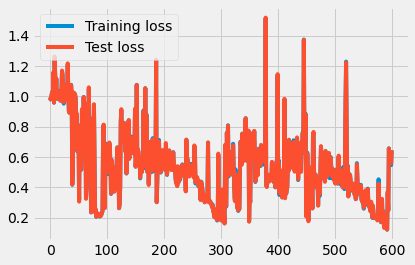

In [0]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
#plt.ylim((0, 5))
plt.legend();

RL Controller Predictor